In [ ]:
pip install fer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 812 kB 27.3 MB/s 
     |████████████████████████████████| 2.3 MB 43.6 MB/s 


In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# api reference: https://metmuseum.github.io/

import urllib.request
import urllib.error
import json
import pickle

urls_list = [
  "https://collectionapi.metmuseum.org/public/collection/v1/search?q=portrait&material=Paintings&departmentId=11", # European Paintings
  "https://collectionapi.metmuseum.org/public/collection/v1/search?q=portrait&departmentId=9" # Drawings and Prints
]

portraits_list = []

# get object ids of all paintings that show up in the search for "portrait" from selected departments
for url in urls_list:
  portraits = urllib.request.urlopen(url).read()
  portraits_list.extend(json.loads(portraits)['objectIDs'])

# list to store json objects returned from MET api

portrait_objects_list = []

In [ ]:
# download images and populate portrait_objects_list
for id in portraits_list:
  # construct url with object id
  url = f'https://collectionapi.metmuseum.org/public/collection/v1/objects/{id}'

  # get json response from api
  # some object ids do not return a result return a 404 error - try/except to filter
  # those out (https://www.edureka.co/community/31707/how-do-i-use-urllib-to-see-if-a-website-is-404-or-200-in-python)
  try:
    url_response = urllib.request.urlopen(url)
  except urllib.error.HTTPError as e:
    print("ERROR IN API GET REQUEST")
    continue # skip this iteration of loop if error is caught
  portrait_obj = json.loads(url_response.read())
  
  # save image if primaryImage url is in json response
  # some primaryImage urls have spaces and are broken - filter these out.
  if portrait_obj['primaryImage'] and ' ' not in portrait_obj['primaryImage']:
    # get url of image file
    portrait_image_url = portrait_obj['primaryImage']

    # download image to google drive folder
    try:
      print(f"download {id}")
      urllib.request.urlretrieve(portrait_image_url, f'gdrive/MyDrive/augment/{id}.jpg')
      # local save
      # urllib.request.urlretrieve(portrait_image_url, f'augment/{id}.jpg')
    except urllib.error.HTTPError as e:
      print("ERROR IN IMAGE DOWNLOAD")
      continue # skip this iteration of loop if error is caught

    # save to portrait_objects_list
    portrait_objects_list.append(portrait_obj)



# save portrait_objects_list to pickle in drive so we dont have to download every time
# (https://stackoverflow.com/questions/25464295/dump-a-list-in-a-pickle-file-and-retrieve-it-back-later)
with open("gdrive/MyDrive/augment/portrait_objects_list.pickle", "wb") as file:
    pickle.dump(portrait_objects_list, file)

download 437875
download 436986
download 436541
download 437056
download 436489
download 436106
download 437490
download 436535
download 436984
download 436243
download 827660
download 436102
download 437507
download 436795
download 438816
download 437488
download 437654
download 438815
download 440209
download 438467
download 436522
download 436703
download 687513
download 437173
download 436722
download 435848
download 436038
download 437990
download 437868
download 437057
download 780292
download 435876
download 436098
download 438107
download 438690
download 437487
download 439327
download 816522
download 436794
download 437869
download 436793
download 435713
download 435666
download 437879
download 437457
download 437061
download 436851
download 436096
download 436105
download 436918
download 437217
download 436686
download 435868
download 436917
download 436252
download 437790
download 436965
download 436516
download 435870
download 437881
download 435869
download 436622
download

In [ ]:
# load portrait_objects_list from pickle if images already downloaded
with open("gdrive/MyDrive/augment/portrait_objects_list.pickle", "rb") as file:
  portrait_objects_list = pickle.load(file)

131

In [ ]:
from fer import FER
import cv2
import pandas as pd

detector = FER(mtcnn=True)

# create empty dataframe for dataset
df = pd.DataFrame(columns = ['met_obj_id', 'title', 'artist', 'year', 'angry',
                             'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral', 'top_emotion'])

for portrait in portrait_objects_list:
  # extract details from portrait
  obj_id = portrait['objectID']
  title = portrait['title']
  artist = portrait['artistDisplayName']
  year = portrait['objectEndDate']
  # read image and detect emotions
  img = cv2.imread(f"gdrive/MyDrive/augment/{obj_id}.jpg")
  faces = detector.detect_emotions(img)
  # iterate over all faces found in portrait
  for face in faces:
    emotions = face['emotions']
    # add to dataset
    df = df.append({
        'met_obj_id': obj_id,
        'title': title,
        'artist': artist,
        'year': year,
        'angry': emotions['angry'],
        'disgust': emotions['disgust'],
        'fear': emotions['fear'],
        'happy': emotions['happy'],
        'sad': emotions['sad'],
        'surprise': emotions['surprise'],
        'neutral': emotions['neutral'],
        'top_emotion': max(emotions, key=emotions.get)
    }, ignore_index = True)


# img = cv2.imread("gdrive/MyDrive/augment/338613.jpg")
# result = detector.detect_emotions(img)
# for face in result:
#   print('issa face')
#   emotions = face['emotions']
#   print(emotions)
#   print(max(emotions, key=emotions.get))
print(df)

    met_obj_id                                              title  \
0       437875                                  Portrait of a Man   
1       436986                                Portrait of a Woman   
2       436541             Sebastián Martínez y Pérez (1747–1800)   
3       437056  Tommaso di Folco Portinari (1428–1501); Maria ...   
4       437056  Tommaso di Folco Portinari (1428–1501); Maria ...   
..         ...                                                ...   
212     356519                      Charles I and Henrietta Maria   
213     361760  Hieronymus Westonius (Richard Weston, Earl of ...   
214     360837              Sir Anthony Van Dyck with a Sunflower   
215     361759     Mary Villiers, Dutchess of Lennox and Richmond   
216     360631                                    Henrietta Maria   

                                   artist  year  angry  disgust  fear  happy  \
0                               Velázquez  1655   0.04      0.0  0.03   0.02   
1          

In [ ]:
#save dataset to csv
df.to_csv("gdrive/MyDrive/augment/dataset.csv")

In [ ]:
#read dataset from csv
dataset = pd.read_csv("gdrive/MyDrive/augment/dataset.csv")

In [ ]:
dataset

,Unnamed: 0,met_obj_id,title,artist,year,angry,disgust,fear,happy,sad,surprise,neutral,top_emotion
0,0,437875,Portrait of a Man,Velázquez,1655,0.04,0.0,0.03,0.02,0.30,0.00,0.61,neutral
1,1,436986,Portrait of a Woman,Quinten Massys,1525,0.03,0.0,0.01,0.00,0.32,0.00,0.64,neutral
2,2,436541,Sebastián Martínez y Pérez (1747–1800),Goya (Francisco de Goya y Lucientes),1792,0.08,0.0,0.05,0.00,0.13,0.00,0.74,neutral
3,3,437056,Tommaso di Folco Portinari (1428–1501); Maria ...,Hans Memling,1475,0.06,0.0,0.01,0.00,0.19,0.00,0.73,neutral
4,4,437056,Tommaso di Folco Portinari (1428–1501); Maria ...,Hans Memling,1475,0.03,0.0,0.01,0.01,0.42,0.01,0.53,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,212,356519,Charles I and Henrietta Maria,Wenceslaus Hollar,1641,0.02,0.0,0.08,0.40,0.43,0.04,0.03,sad
213,213,361760,"Hieronymus Westonius (Richard Weston, Earl of ...",Wenceslaus Hollar,1645,0.18,0.0,0.13,0.15,0.53,0.00,0.01,sad
214,214,360837,Sir Anthony Van Dyck with a Sunflower,Wenceslaus Hollar,1644,0.05,0.0,0.08,0.46,0.38,0.00,0.02,happy
215,215,361759,"Mary Villiers, Dutchess of Lennox and Richmond",Wenceslaus Hollar,1650,0.03,0.0,0.03,0.02,0.88,0.00,0.03,sad


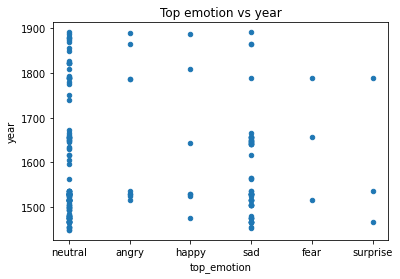

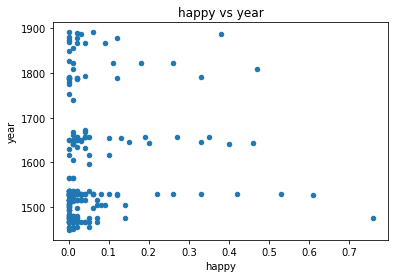

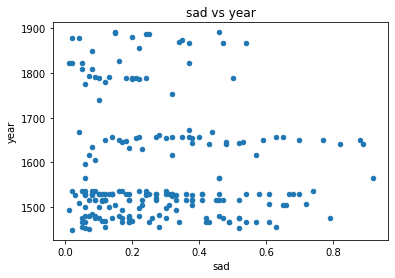

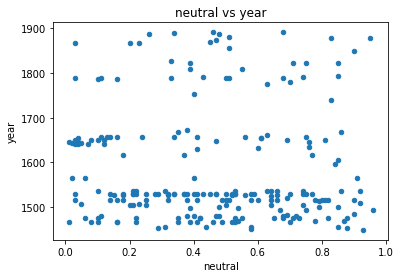

In [ ]:
# visualizations

dataset.plot.scatter(x="top_emotion", y="year", title="Top emotion vs year")

dataset.plot.scatter(x="happy", y="year", title="happy vs year")

dataset.plot.scatter(x="sad", y="year", title="sad vs year")
dataset.plot.scatter(x="neutral", y="year", title="neutral vs year")